In [1]:
! pip install rootutils
! pip install mediapy

In [28]:
import cv2
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import rootutils
import mediapy
from scipy.spatial.transform import Rotation

#  auto-reloads all modules
%load_ext autoreload
%autoreload 2 

# import python modules relatively to the project root directory
root = rootutils.setup_root(".", indicator="homeworks", pythonpath=True)

# data directory
DATA_DIR = root / "data"
print(f"DATA_DIR: {DATA_DIR}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
DATA_DIR: /Users/alex/image-processing/data


In [31]:
# вспомогательные функции для визуализации

# функция для визуализации точек и рёбер в 3D
def plot_points(points, edges=None, plots=None):
    if plots is None:
        plots = []

    u = points[:, 0]
    v = points[:, 1]
    w = points[:, 2]

    num_points = len(points)

    p = px.scatter_3d(
        x=u, y=v, z=w,
        color=num_points * ["rgb(255, 0, 255)"],
        color_discrete_map="identity"
    )
    p.update_traces(marker_size=3)
    plots.append(p)

    if edges is None:
        return plots
    
    for n, m in edges:
        u1, v1, w1 = points[n]
        u2, v2, w2 = points[m]

        p = px.line_3d(x=[u1, u2], y=[v1, v2], z=[w1, w2])
        p.update_traces(line=dict(color="gray", width=3))
        plots.append(p)

    return plots


# функция для отображения 3D сцены
def show_plots(plots, width, height, eye):
    data = []

    for p in plots:
        data += p.data

    fig = go.Figure(data)

    fig.update_layout(autosize=True, width=width, height=height, paper_bgcolor="black",
        scene=dict(
            aspectmode="data",
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
    
    view = dict(
        eye=dict(x=eye[0], y=eye[1], z=eye[2]),
        center=dict(x=0, y=0, z=0),
        up=dict(x=0, y=0, z=1)
    )

    fig.update_layout(scene_camera=view)
    fig.show()

**Загрузка 3D сцены**

In [32]:
points3D = np.loadtxt(DATA_DIR / "box.xyz")
print(f"3D points shape: {points3D.shape}")

3D points shape: (160, 3)


**Построение 3D точек сцены**

In [33]:
plots = plot_points(points3D)
show_plots(plots, width=600, height=600, eye=(2, 2, 1.5))

**Внутренние и внешние параметры камер**

In [35]:
# У всех камер одинаковые внутренние параметры
f, cx, cy = 1000, 320, 240

K = np.array([
    [f, 0, cx], 
    [0, f, cy], 
    [0, 0, 1]
])

# Внешние параметры камер - матрицы вращения и векторы трансляции
# из мировой системы координат в систему координат камер

# векторы вращения 5 камер, параметризующие матрицы вращения
rotation_vectors = np.array([
    [0, 0, 0],
    [0.26029898, -0.26029898,  0.03426901],
    [-0.26029898,  0.26029898,  0.03426901],
    [-0.26029898, -0.26029898, -0.03426901],
    [0.26029898,  0.26029898, -0.03426901]
])

# вектора трансляции 5 камер
translations = np.array([
    [0, 0, 0],
    [1.79787706, 1.93185165, 1.01763809],
    [-1.79787706, -1.93185165,  1.01763809],
    [ 1.79787706, -1.93185165,  1.01763809],
    [-1.79787706,  1.93185165,  1.01763809]
])


**Спроектируем 3D-точки на изображения камер**

In [36]:
# будем добавлять шум к проекциям точек
# для воспроизводимости результатов зафиксируем seed генератора случайных чисел
np.random.seed(0xC0FFEE)

# элементы этого списка - проекции 3D точек на изображения камер
camera_points2D = []

for camera_id in range(4):
    # получаем внешние параметры камеры
    omega = rotation_vectors[camera_id]
    t = translations[camera_id]

    # проецируем 3D точки на изображение камеры c помощью OpenCV
    points2D, _ = cv2.projectPoints(
        points3D[None],
        omega.reshape(3, 1),
        t.reshape(3, 1),
        K,
        np.zeros((5, 1)) # коэффициеты дисторсии
    )
    points2D = points2D.reshape(-1, 2)

    # добавляем гауссовский шум к проекциям точек
    noise_std = 2.0
    noise = np.random.normal(scale=noise_std, size=(len(points2D), 2))
    points2D += noise

    # добавляем проекции точек этой камеры в список
    camera_points2D.append(points2D)

**Отобразим проекции точек на изображениях камер**

Camera 0,Camera 1
Camera 2,Camera 3

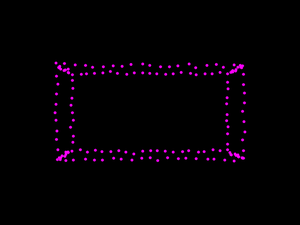
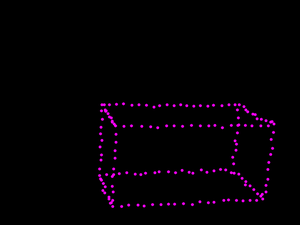
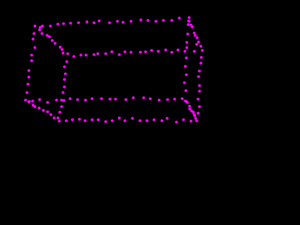
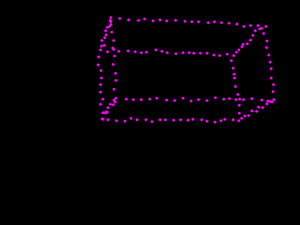

In [37]:
# список изображений камер с проекциями точек
camera_images = []

for camera_id in range(4):
    # создаём пустое изображение
    image_height = int(2 * cy)
    image_width = int(2 * cx)

    image = np.zeros((image_height, image_width, 3), dtype=np.uint8)

    # получаем проекции точек для этой камеры
    points2D = camera_points2D[camera_id]

    # рисуем проекции точек на изображении камеры
    for x, y in points2D.astype(int):
        cv2.circle(image, (x, y), 3, (255, 0, 255), -1)

    # добавляем изображение этой камеры в список
    camera_images.append(image)

# отображаем изображения камер с проекциями точек
mediapy.show_images({
    "Camera 0": camera_images[0], "Camera 1": camera_images[1],
    "Camera 2": camera_images[2], "Camera 3": camera_images[3]
}, border=True, width=300, columns=2)

#### **Оценка внешних параметров камеры (PnP problem)**

Нахождение внешних параметров камеры (матрицы поворота и вектора трансляции) на основе известных внутренних параметров камеры и набора соответствий между 3D-точками сцены и их проекциями на изображение камеры.

Формально, задача оптимизации для оценки внешних параметров камеры может быть записана как минимизация функции правдоподобия:
$$
    \widehat{\mathbf{R}}\,,\,\, \widehat{\mathbf{t}} =
    \argmin_{\mathbf{R}\,,\,\mathbf{t}} 
    \left(- \sum_{i=1}^{I} 
    \ln \left[ Pr(\mathbf{x}_i\,|\,\mathbf{w}_i, \mathbf{K}, \mathbf{R}, \mathbf{t})\right]
    \right)
$$

**Найдем внешние параметры камеры с помощью библиотеки OpenCV**

In [ ]:
# номер камеры, для которой будем находить внешние параметры
camera_id = 3

# получаем проекции точек для этой камеры
points2D = camera_points2D[camera_id]

# нелинейная оптимизация решения задачи PnP с помощью OpenCV
_, cv_omega, cv_t = cv2.solvePnP(
    points3D, 
    points2D, 
    K, 
    np.zeros(4) # коэффициеты дисторсии
)

# оценки внешних параметров камеры
cv_omega = cv_omega.flatten()
cv_t = cv_t.flatten()

# получаем истинные внешние параметры камеры
gt_omega = rotation_vectors[camera_id]
gt_t = translations[camera_id]

# вычислим ошибки оценки внешних параметров камеры c помощью нелинейной оптимизации
rotation_error = np.linalg.norm(cv_omega - gt_omega) / np.linalg.norm(gt_omega)
print(f"Opencv rotation error: {100 * rotation_error: .2f}%")

translation_error = np.linalg.norm(cv_t - gt_t) / np.linalg.norm(gt_t)
print(f"Opencv translation error: {100 * translation_error: .2f}%")

Opencv rotation error:  0.92%
Opencv translation error:  0.41%


**Оценка внешних параметров камеры c помощью метода DLT**

$$
    \begin{bmatrix}
        u_i & v_i & w_i & 1 & 0 & 0 & 0 & 0 & -x_i' u_i & -x_i' v_i & -x_i' w_i & -x_i' \\
        0 & 0 & 0 & 0 & u_i & v_i & w_i & 1 & -y_i' u_i & -y_i' v_i & -y_i' w_i & -y_i'
    \end{bmatrix}
    \boldsymbol{\theta} = 
    \mathbf{0}
$$
где
$$
    \boldsymbol{\theta} =
    \begin{bmatrix}
        r_{11} & r_{12} & r_{13}  & t_1 &
        r_{21} & r_{22} & r_{23}  & t_2 &
        r_{31} & r_{32} & r_{33}  & t_3
    \end{bmatrix}^\top
$$  
$$
    \begin{bmatrix}
        x_i' \\ y_i' \\ 1
    \end{bmatrix} =
    \mathbf{K}^{-1}
    \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix}
$$  
Каждая точка дает два уравнения. 
Соберем уравнения от всех точек в одну систему 
$$
    \mathbf{A} \cdot \boldsymbol{\theta} = \mathbf{0}
$$

#### **Задача 1**

Напишите функцию, которая реализует метод DLT для оценки внешних параметров камеры.

```python
# file: homeworks/homework_08.py

def solvePnP_DLT(points3D, points2D, K):
    ...
    # возвращаем оценки для вектора вращения omega и трансляции t
    return omega, t
```

Протестируем функцию `solvePnP_DLT`.

In [46]:
from homeworks.homework_08 import solvePnP_DLT

# DLT оценки вектора вращения и трансляции камеры
dlt_omega, dlt_t = solvePnP_DLT(points3D, points2D, K)

# вычислим ошибки оценки внешних параметров камеры c помощью метода DLT
rotation_error = np.linalg.norm(dlt_omega - gt_omega) / np.linalg.norm(gt_omega)
print(f"DLT rotation error: {100 * rotation_error: .2f}%")

translation_error = np.linalg.norm(dlt_t - gt_t) / np.linalg.norm(gt_t)
print(f"DLT translation error: {100 * translation_error: .2f}%")

DLT rotation error:  3.36%
DLT translation error:  5.79%


#### **Реконструкция 3D точек сцены (triangulation problem)**

По проекциям 3D-точек сцены на несколько изображений камер и известным внутренним и внешним параметрам камер восстановим 3D-точки сцены.

Решение задачи триангуляции с помощью нелинейной оптимизации функции правдоподобия:

$$
    \widehat{\mathbf{w}} =
    \argmin_{\mathbf{w}} 
    \left(- \sum_{j=1}^{J} 
    \ln \left[ Pr(\mathbf{x}_j\,|\,\mathbf{w}, \mathbf{K}_j, \mathbf{R}_j, \mathbf{t}_j)\right]
    \right)
$$

**Найдем координаты 3D-точек сцены с помощью OpenCV**

In [47]:
# функция, вычисляющая матрицу камеры
def calc_camera_matrix(K, omega, t):
    R = Rotation.from_rotvec(omega).as_matrix()
    P = K @ np.hstack((R, t.reshape(3, 1)))
    return P

# матрицы двух камер
P1 = calc_camera_matrix(K, rotation_vectors[1], translations[1])
P2 = calc_camera_matrix(K, rotation_vectors[2], translations[2])


In [49]:
# функция, вычисляющая 3D-точки с помощью OpenCV
def opencv_triangulate_points(P1, P2, pts1, pts2):
    w = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    
    w /= w[3]
    w = w.T[:, :3]

    return w

# точки на изображениях двух камер
pts1 = camera_points2D[1]
pts2 = camera_points2D[2]

# оценка 3D-точек с помощью OpenCV
cv_points3D = opencv_triangulate_points(P1, P2, pts1, pts2)

# ошибка реконструкции 3D-точек с помощью OpenCV
cv_error = np.linalg.norm(cv_points3D - points3D, axis=1).mean()
print(f"Opencv triangulation error: {cv_error:.4f}")

Opencv triangulation error: 0.0203


**Реконструкция 3D-точек с помощью метода DLT**

Каждая камера дает две строки в системе уравнений 
    $$
        \begin{bmatrix}
            r_{31}^j x_j' - r_{11}^j & r_{32}^j x_j' - r_{12}^j & r_{33}^j x_j' - r_{13}^j \\
            r_{31}^j y_j' - r_{21}^j & r_{32}^j y_j' - r_{22}^j & r_{33}^j y_j' - r_{23}^j
        \end{bmatrix}
        \mathbf{w} = 
        \begin{bmatrix}
            t_1^j - t_3^j x_j'\\ 
            t_2^j - t_3^j y_j'
        \end{bmatrix}
    $$

где
$$
    \mathbf{w} =
    \begin{bmatrix}
        u \\ v \\ w
    \end{bmatrix}\,,
    \qquad
    \begin{bmatrix}
        x_i' \\ y_i' \\ 1
    \end{bmatrix} =
    \mathbf{K}^{-1}
    \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix}
$$

- Соберем уравнения от всех камер в одну систему 
$$
    \mathbf{A} \cdot \mathbf{w} = \mathbf{b}
$$

- Найдем решение этой системы уравнений как задачу оптимизации:
    $$
        \widehat{\mathbf{w}} =
        \argmin_{\mathbf{w}} \|\mathbf{A} \cdot \mathbf{w} - \mathbf{b}\|^2
    $$

- Решение ищется с помощью метода наименьших квадратов.
    

##### **Задача 2**
Напишите функцию, которая реализует метод DLT для реконструкции 3D-точек сцены.

```python
# file: homeworks/homework_08.py
def triangulate_DLT(rotation_vectors, translations, camera_points2D, K):
    ...
    # возвращаем оценки для 3D-точек сцены
    return points3D
```

Тестируем функцию `triangulate_DLT`:

In [52]:
from homeworks. homework_08 import triangulate_DLT

# оценка 3D-точек с помощью DLT алгоритма
dlt_points3D = triangulate_DLT(rotation_vectors, translations, camera_points2D, K)

# ошибка реконструкции 3D-точек с помощью DLT алгоритма
dlt_error = np.linalg.norm(dlt_points3D - points3D, axis=1).mean()
print(f"DLT triangulation error: {dlt_error:.4f}")

DLT triangulation error: 0.0159


### **Домашнее задание 8**

#### **Теоретическая часть**

- Генеративная модель pinhole-камеры.

- Метод максимального правдоподобия для оценки параметров распределения наблюдаемых данных.

- Методы нелинейной оптимизации для квадратичных функций.

- Оценка внешних параметров камеры (PnP problem).
  Оценка внешних параметров камеры с помощью метода DLT.

- Реконструкция 3D точек сцены (triangulation problem).
  Реконструкция 3D-точек с помощью метода DLT.

- Оценка внутренних параметров камеры (camera calibration problem).
  
##### **Практическая часть**
Реализуйте в файле `homeworks/homework_08.py` функции из задач 1 и 2.

Протестируйте их в ноутбуке `notebooks/notebook_08.ipynb`.